# Aggregation: Sum

This notebook is a deep-dive on transformations for computing the sum with bounded stability.

---
Any constructors that have not completed the proof-writing and vetting process may still be accessed if you opt-in to "contrib".
Please contact us if you are interested in proof-writing. Thank you!

In [2]:
import opendp.prelude as dp
dp.enable_features("contrib")

## Known/Unknown Dataset Size
Constructing a sum transformation is easy!
First, describe the metric space you are working in. 
This can also be filled in from the previous transformation.

In [3]:
# the space of all integer vectors,
# where distances between vectors are measured by the symmetric distance
input_space = dp.vector_domain(dp.atom_domain(bounds=(0, 10))), dp.symmetric_distance()

Then construct the sum transformation:

In [ ]:

sum_trans = input_space >> dp.t.then_sum()

# compute the sum
assert sum_trans([1, 2, 4]) == 7   # 1 + 2 + 4

# compute the sensitivity
assert sum_trans.map(d_in=1) == 10 # d_in * max(|L|, U)

In the integer case, since the sensitivity is scaled by $max(|L|, U)$, the sensitivity won't increase if you were to widen $L$ to $min(L, -U)$, or widen $U$ to $max(-L, U)$.
This doesn't hold for floating-point datasets with unknown size, for reasons we'll cover in the next section.

If the dataset size is public information, then restrict the input space:

In [4]:
# the space of all length-3 integer vectors,
# where distances between vectors are measured by the symmetric distance
input_space = dp.vector_domain(dp.atom_domain(bounds=(-10, 10)), size=3), dp.symmetric_distance()
sum_trans = input_space >> dp.t.then_sum()

# compute the sum
assert sum_trans([1, 2, 4]) == 7   # 1 + 2 + 4

# compute the sensitivity
assert sum_trans.map(d_in=2) == 20 # (d_in // 2) * (U - L)

Since the sensitivity is scaled by $U - L$, the sensitivity won't increase if you shift both bounds by the same fixed constant. Therefore, the sensitivity remains small in situations where $L$ and $U$ share the same sign and are large in magnitude.

_All_ sum transformations expect a `d_in` in terms of the `SymmetricDistance`.
However, when the dataset size is known, we are operating in the bounded-DP regime where adjacent datasets have the same size.
This means it takes both an addition and a removal to change any single record, to reach any adjacent dataset.
This results in a stair-step relationship between $d_{in}$ and $d_{out}$:

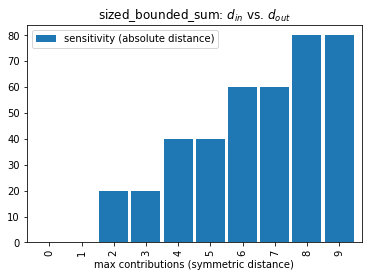

In [5]:
import pandas as pd
pd.DataFrame(
    [(d_in, sum_trans.map(d_in)) for d_in in range(10)], 
    columns=["max contributions (symmetric distance)", "sensitivity (absolute distance)"]
).plot.bar(0, title="sized_bounded_sum: $d_{in}$ vs. $d_{out}$", width=0.9);

Intuitively, if we say the symmetric distance between adjacent datasets is at most one, and all adjacent datasets differ by an even number of additions and removals, then the sensitivity is zero.

## Floating-Point

Floating-point addition is not closed, that is, 
adding two floating point numbers doesn't necessarily result in another floating-point number.
To resolve this, the IEEE-754 floating-point standard requires a rounding to the nearest floating-point number.
Unfortunately, this influences the sensitivity of the summation.

In the OpenDP Library, stability maps account for the increased sensitivity due to floating-point rounding in intermediate operations by adding an additional constant term that scales with the dataset size.

In [7]:
input_space = dp.vector_domain(dp.atom_domain(bounds=(-10., 10.)), size=1000), dp.symmetric_distance()
sum_trans = input_space >> dp.t.then_sum()

# The sensitivity is now slightly larger than 20 because of the floating-point constant term
print(sum_trans.map(d_in=2))

20.00000000004426


Unfortunately, the worst-case sensitivity analysis hits a snag when the dataset size is unknown, as the rounding error becomes unbounded.

To keep the sensitivity finite, a dataset truncation operation is applied first:
The dataset size is reduced to no greater than $2^{20}$ elements (a little over 1 million records), if necessary, via a simple random sample.

The dataset truncation also causes a regression in the sensitivity, as it it is now scaled by $max(|L|, U, U - L)$. 
This accounts for the case where an adjacent dataset with one additional row needs to drop a random row to preserve the dataset size.
In practice, the worst-case penalty on the sensitivity is when $L = -U$. 

In [8]:
# show the worst-case degradation
input_space = dp.vector_domain(dp.atom_domain(bounds=(-10., 10.))), dp.symmetric_distance()
sum_trans = input_space >> dp.t.then_sum()

# the sensitivity is now scaled by max(|L|, U, U - L) = max(|-10.|, 10., 10. - -10.) = 20.
print(sum_trans.map(d_in=1))

20.00000009313226


If the bounds share the same sign, then the sensitivity remains unchanged, save for the constant term to account for float rounding.

In [9]:
# if the bounds share sign, the sensitivity is unaffected
input_space = dp.vector_domain(dp.atom_domain(bounds=(-10., 0.))), dp.symmetric_distance()
sum_trans = input_space >> dp.t.then_sum()

# the sensitivity is now scaled by max(|L|, U, U - L) = max(|-10.|, 0., 0. - -10.) = 10.
print(sum_trans.map(d_in=1))

10.00000009313226


## Specialized Floating-Point Constructors

In the previous section an arbitrary limit of ($2^{20}$) on dataset size was baked into the constructor,
to help simplify the library interface.
This limit be manipulated by calling the appropriate constructor:

In [10]:
dp.t.make_bounded_float_checked_sum(size_limit=100, bounds=(-10., 0.)).map(d_in=1)

10.00000000000295

The size of the relaxation term varies according to the dataset size, magnitude of the bounds, summation algorithm and floating-point bit depth.
The following visualization shows the effect of dataset size and choice of algorithm.

To isolate the relaxation term for this visualization, the sensitivity is calculated for the case when datasets differ by zero additions or removals.
A dataset with the same rows but a different row ordering will result in a different answer for the same sum query.

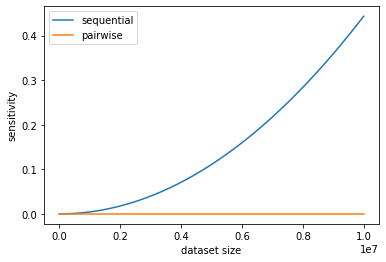

In [11]:
bounds = (0., 10.)
sizes = list(range(1, 10_000_000, 10_000))

pd.DataFrame({
    "dataset size": sizes,
    "sequential": [dp.t.make_sized_bounded_float_checked_sum(size, bounds, S="Sequential<f64>").map(0) for size in sizes],
    "pairwise": [dp.t.make_sized_bounded_float_checked_sum(size, bounds, S="Pairwise<f64>").map(0) for size in sizes],
}).plot(0, ylabel="sensitivity");

The increase to sensitivity when using a sequential summation algorithm grows on the order of $O(n^2)$, while the pairwise algorithm grows on the order of $O(n \log_2(n))$.

OpenDP defaults to the pairwise algorithm, but the ability to configure the algorithm can be useful to calculate the sensitivity in situations where you don't have control over how the summation is computed.
For example, floating-point aggregations in SQLite and MySQL both exhibit increases in sensitivity akin to the sequential algorithm.

Beware, these relaxation terms grow far more quickly when the data type is adjusted to single-precision floats (`f32`)!






## Specialized Integer Constructors

Just as in the case for floating-point types, there are specialized constructors for summation over integral types.

The integral transformations from `make_sum` use properties of the bounds, data types and input metric to determine which strategy to use to compute the sum in a way that protects the sensitivity from the effects of numerical overflow.

The following strategies are ordered by computational efficiency:

* ``checked`` can be used when the dataset size multiplied by the bounds doesn't overflow.
* ``monotonic`` can be used when the bounds share the same sign.
* ``ordered`` can be used when the input metric is ``InsertDeleteDistance``.
* ``split`` separately sums positive and negative numbers, and then adds these sums together.

``monotonic``, ``ordered`` and ``split`` are implemented with saturation arithmetic. 
``checked``, ``monotonic`` and ``split`` protect against underestimating sensitivity by preserving associativity.

These each have their own uses.
For example, if the dataset is considered ordered-- that is, the dataset distance metric is sensitive to changes in row ordering (`InsertDeleteDistance`), then neighboring datasets share the same row ordering, and it becomes safe to use arithmetic that saturates at the minimum and maximum representable values of the data type.

In [3]:
# because of the way this constructor is called...
dp.t.make_sum(dp.vector_domain(dp.atom_domain(bounds=(1, 20))), dp.insert_delete_distance())
# ...it internally uses this constructor to build the transformation:
dp.t.make_bounded_int_ordered_sum(bounds=(1, 20))

If you are trying to model a computation performed outside of OpenDP, you may not have access to saturation arithmetic.
If this is the case, you can use `make_sized_bounded_int_checked_sum` to perform an overflow check at the moment the constructor is called.

In [18]:
# Configure the type argument "T" to determine the necessary bit depth to avoid overflow
dp.t.make_sized_bounded_int_checked_sum(1234, (-2, 4), T="i32")